# Comparative Analysis
In this notebook, we compare ClaSS with competitors.

In [42]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [43]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

from critdd import Diagram
from src.utils import save_tikz
from external.MCM import MCM

sns.set_theme()
sns.set_color_codes()

import os
import sys

sys.path.append("../../")

from tqdm import tqdm

Let's choose a score for evaluation (F1 or Covering).

In [44]:
eval_score = "covering_score"

Let's load the scores from the different methods.

In [45]:
competitors = ["BinSeg", "ClaSP", "DDRE", "FLUSS", "Pelt", "RuLSIF", "Window"]
datasets = ["UTSA", "TSSB", "HAS"]
methods, dfs = list(), list()

for candidate_name in competitors:
    methods.append((candidate_name, f"{candidate_name}.csv.gz"))

for idx, (name, file_name) in enumerate(tqdm(methods)):
    df = []

    for d in datasets:
        df.append(pd.read_csv(f"../../experiments/segmentation/{d}_{file_name}", usecols=["dataset", eval_score],
                              compression="gzip"))

    df = pd.concat(df)
    df.sort_values(by="dataset", inplace=True)
    dfs.append((name, df))

df_scores = pd.DataFrame()

for name, df in dfs:
    df_scores["dataset"] = df.dataset
    df_scores[name] = df[eval_score]

df_scores.reset_index(drop=True, inplace=True)
df_scores

100%|██████████| 7/7 [00:00<00:00, 67.49it/s]


,dataset,BinSeg,ClaSP,DDRE,FLUSS,Pelt,RuLSIF,Window
0,Adiac,0.303,0.807,0.325,0.430,0.303,0.358,0.303
1,ArrowHead,0.500,0.985,0.219,0.995,0.500,0.199,0.500
2,Beef,0.500,0.973,0.678,0.935,0.500,0.633,0.500
3,BeetleFly,0.652,0.975,0.150,0.500,0.652,0.178,0.500
4,BirdChicken,0.500,0.994,0.258,0.500,0.500,0.280,0.500
5,CBF,0.342,0.979,0.537,0.861,0.342,0.621,0.342
6,Cane,0.937,0.778,0.517,0.741,0.937,0.413,0.935
7,Car,0.256,0.742,0.411,0.256,0.256,0.353,0.256
8,Chinatown,1.000,1.000,0.333,0.704,1.000,0.412,1.000
9,ChlorineConcentration,0.577,0.577,0.046,0.577,0.577,0.056,0.577


Let's calculate the mean/median/std score.

In [46]:
df_scores.iloc[:,1:].mean(axis=0).sort_values().round(3)

RuLSIF    0.383
DDRE      0.387
Pelt      0.479
BinSeg    0.502
FLUSS     0.534
Window    0.581
ClaSP     0.743
dtype: float64

In [47]:
df_scores.iloc[:,1:].median(axis=0).sort_values().round(3)

DDRE      0.373
RuLSIF    0.375
Pelt      0.440
BinSeg    0.486
FLUSS     0.500
Window    0.550
ClaSP     0.796
dtype: float64

In [48]:
df_scores.iloc[:,1:].std(axis=0).round(3)

BinSeg    0.236
ClaSP     0.230
DDRE      0.208
FLUSS     0.275
Pelt      0.237
RuLSIF    0.204
Window    0.219
dtype: float64

Let's compute the wins per method.

In [49]:
ranks = df_scores.iloc[:,1:].rank(1, method='min', ascending=False)
means = np.array(ranks.mean(axis=0))
args = np.argsort(means)

In [50]:
for mean, name in zip(means[args], df_scores.columns[1:].to_numpy()[args]):
    print(f"{name}:wins={ranks[ranks[name] == 1].shape[0]} rank={np.round(mean, 1)}")

ClaSP:wins=212 rank=2.1
Window:wins=89 rank=2.7
FLUSS:wins=77 rank=3.7
BinSeg:wins=36 rank=3.9
Pelt:wins=32 rank=4.3
DDRE:wins=9 rank=4.9
RuLSIF:wins=10 rank=5.0


Let's plot the CD diagram.

/Users/ermshaua/miniconda3/envs/clap/lib/python3.9/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


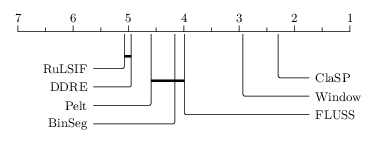

In [51]:
diagram = Diagram(
    df_scores.iloc[:, 1:].to_numpy(),
    treatment_names=df_scores.columns[1:].to_numpy(),
    maximize_outcome=True
)

tikz_code = diagram.to_str(
    alpha=.05,
    adjustment="holm",
    reverse_x=True,
    as_document=True
)

from wand.image import Image

cd_path = "../../figures/cd_segmentation_comparative_combined.pdf"
save_tikz(cd_path, tikz_code)
Image(filename=cd_path, resolution=100)

Let's plot the MCM.

Processing Window, RuLSIF:   0%|          | 0/7 [00:00<?, ?it/s]


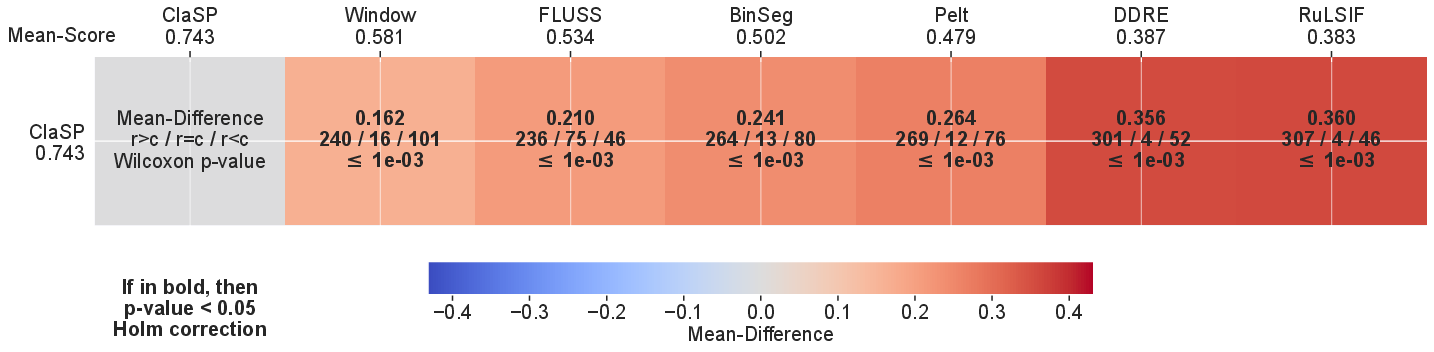

In [52]:
dir_path = "../../figures/"
file_name = "mcm_segmentation_comparative_combined"

MCM.compare(
    output_dir=dir_path,
    used_statistic="Score",
    save_as_json=False,
    df_results=df_scores.iloc[:, 1:],
    pdf_savename=file_name,
    load_analysis=False,
    pvalue_correction="Holm",
    row_comparates=("ClaSP",),
    fig_size=(20,5),
    font_size=20,
    precision=3
)
Image(filename=os.path.join(dir_path, file_name + ".pdf"))

Let's compute wins/losses against ClaSP.

In [53]:
selection = "ClaSP"

for rival in df_scores.columns[1:]:
    if rival == selection: continue

    df_pair = df_scores[[selection, rival]]
    pair_ranks = df_pair.rank(1, method='min', ascending=False)

    wins = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 2)].shape[0]
    losses = pair_ranks[(pair_ranks[selection] == 2) & (pair_ranks[rival] == 1)].shape[0]
    ties = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 1)].shape[0]

    assert wins + losses + ties == pair_ranks.shape[0]

    print(f"{selection} vs {rival}: (wins/ties/losses): {wins}/{ties}/{losses}")

ClaSP vs BinSeg: (wins/ties/losses): 264/13/80
ClaSP vs DDRE: (wins/ties/losses): 301/4/52
ClaSP vs FLUSS: (wins/ties/losses): 236/75/46
ClaSP vs Pelt: (wins/ties/losses): 269/12/76
ClaSP vs RuLSIF: (wins/ties/losses): 307/4/46
ClaSP vs Window: (wins/ties/losses): 240/16/101


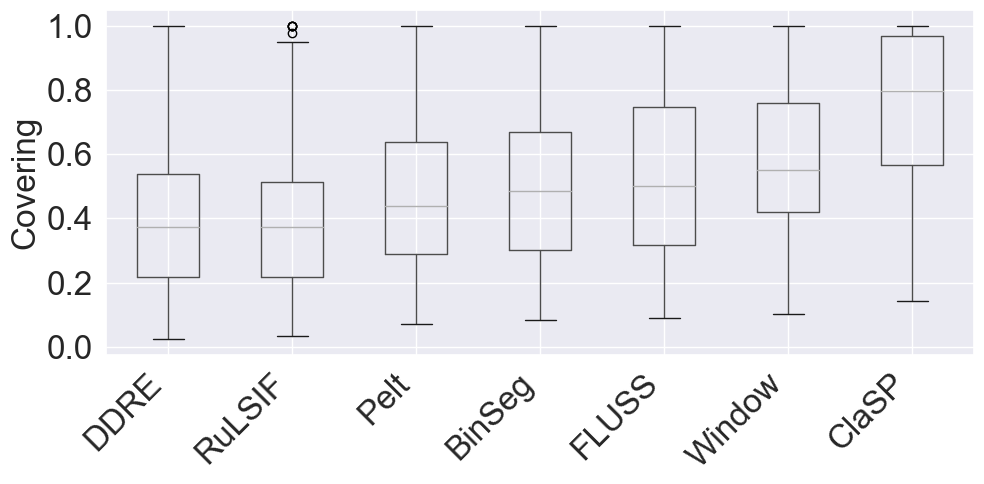

In [54]:
fontsize = 24
_, ax = plt.subplots(figsize=(10, 5))

# sort by median performance
df_sorted_scores = df_scores[df_scores.iloc[:, 1:].median(axis=0).sort_values().index]

df_sorted_scores.boxplot(ax=ax, rot=90)
ax.set_ylabel("Covering", fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xticklabels(df_sorted_scores.columns, rotation=45, ha="right")
ax.set_yticks(np.round(np.arange(0, 1.0 + .2, .2), 1))

plt.savefig(f"../../figures/bp_segmentation_comparative_combined.pdf", bbox_inches="tight")